In [1]:
path = '/data/workspace_files/mrob/lib'
import sys
sys.path.append(path)
%cd /data/workspace_files/mrob/lib

/data/workspace_files/mrob/lib


In [2]:
import mrob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm
from scipy.optimize import minimize

In [3]:
mocap = pd.read_csv("https://raw.githubusercontent.com/kolchindru/imu_research/master/ground_truth.csv", names=['time', 'p1', 'p2', 'p3', 'qw', 'qx', 'qy', 'qz'])[1:]
data = pd.read_csv("https://raw.githubusercontent.com/kolchindru/imu_research/master/data_2.csv", names=['time', 'omega1', 'omega2', 'omega3', 'a1', 'a2', 'a3'])[1:]
data = data.astype("float64")
mocap = mocap.astype("float64")

In [4]:
def preprocess_datasets(angles, ground_truth):
    angles['delta_t'] = angles.diff()['time'].apply(lambda x: x/pow(10, 9))
    ground_truth['delta_t'] = ground_truth.diff()['time'].apply(lambda x: x/pow(10, 9))
    angles['dt'] = pd.to_datetime(angles['time'])
    ground_truth['dt'] = pd.to_datetime(ground_truth['time'])
    ground_truth.set_index('dt', inplace=True)
    ground_truth.index = pd.to_datetime(ground_truth.index)
    
    return angles, ground_truth

def sync_datasets(angles, ground_truth):
    meas = angles.set_index("dt")
    newindex = meas.index.union(ground_truth.index)
    ground_truth = ground_truth.reindex(newindex).fillna(method='pad').filter(meas.index, axis=0)
    ground_truth = ground_truth.dropna()
    meas = meas.filter(ground_truth.index, axis=0)
    return meas, ground_truth

In [5]:
data, mocap = preprocess_datasets(data, mocap)
data, mocap = sync_datasets(data, mocap)

In [133]:
dt = np.array(data.delta_t)
angle_v = np.array(data[['omega1', 'omega2', 'omega3']])
angle_a = np.array(data[['a1', 'a2', 'a3']])

In [134]:
gt_positions = np.array(mocap[['p1', 'p2', 'p3']])
gt_quat_xyz = np.array(mocap[['qx', 'qy', 'qz']])
gt_quat_w = np.array(mocap.qw)
gt_quat = np.zeros((gt_quat_xyz.shape[0], 4))
gt_quat[:, :3] = gt_quat_xyz
gt_quat[:, 3] = gt_quat_w

In [220]:
class RBT_rotation:
    def __init__(self, dt, angle_v, gt_quat, start=0, num_iterations=None, bias=None):
        if not bias is None:
            angle_v[start:num_iterations] = bias[start:num_iterations]
        self.dt = dt
        self.n = dt.shape[0] - 1 if not num_iterations else num_iterations
        self.angle_v = angle_v
        self.gt_quat = gt_quat
        self.i = start
        self.R = mrob.geometry.quat_to_so3(self.gt_quat[self.i])
        self.R = mrob.geometry.SO3(self.R)
        self.rotation_errors_history = []

    def get_gt_SE3(self):
        gt_SO3 = mrob.geometry.quat_to_so3(self.gt_quat[self.i])
        gt_SO3 = mrob.geometry.SO3(gt_SO3)
        gt_SE3 = mrob.geometry.SE3(gt_SO3, np.array([0, 0, 0]))

        return gt_SE3 
    
    def get_estimated_SE3(self):
        estimated_SO3 = self.R
        estimated_SE3 = mrob.geometry.SE3(estimated_SO3, np.array([0, 0, 0]))
        return estimated_SE3

    def rotate(self, gyro_bias=np.zeros(3)):
        rotation_vector = self.angle_v[self.i] - gyro_bias
        R_i = mrob.geometry.SO3(rotation_vector * self.dt[self.i])
        self.R = R_i.mul(self.R)

    def rotation_error(self):
        gt_pose = self.get_gt_SE3()
        estimated_pose = self.get_estimated_SE3()
        rotation_error = gt_pose.distance_rotation(estimated_pose)
        self.rotation_errors_history.append(rotation_error)

        return rotation_error

    def integrate_full(self, gyro_bias=np.zeros(3)):
        for iteration in range(self.n):
            self.rotate(gyro_bias=gyro_bias)
            self.i += 1
            rotation_error = self.rotation_error()

        self.i = 0

        return rotation_error

In [88]:
def biased_integration(bias):
    rbt = RBT_rotation(dt, angle_v, gt_quat, start=n, num_iterations=optimization_step)
    rotation_error = rbt.integrate_full(gyro_bias=bias)
    return rotation_error

In [235]:
optimization_step = 500

results = []
for n in range(0, 59000, optimization_step):
    print(n)
    res = minimize(biased_integration, np.zeros(3), options={"maxiter": 5})
    for j in range(optimization_step):
        results.append(list(res.x))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500


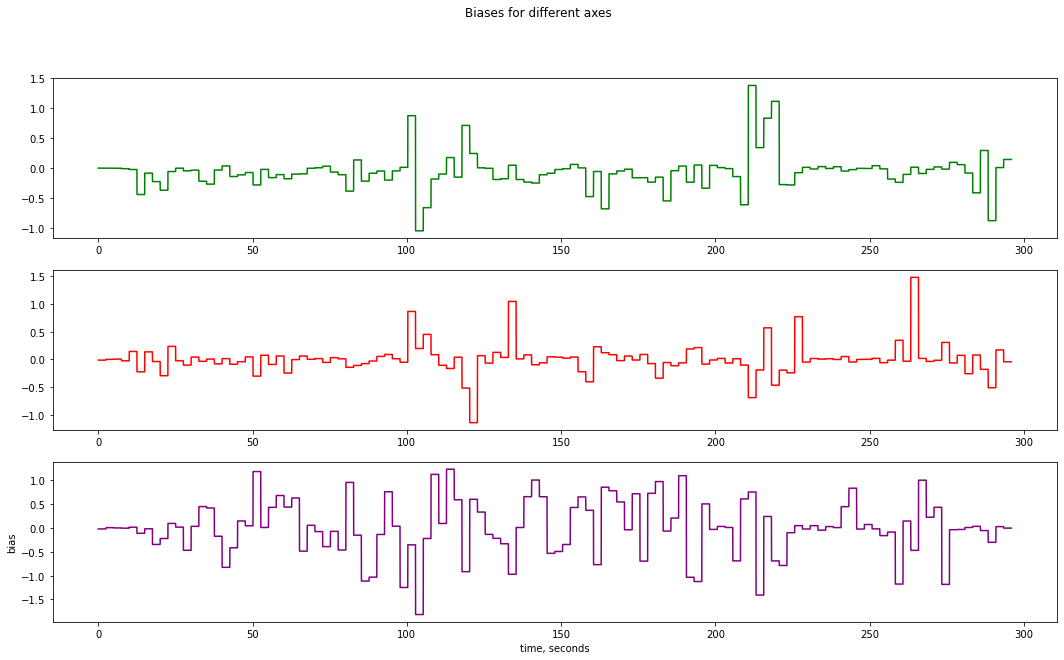

In [236]:
results = np.array(results)

b_x = results[:, 0]
b_y = results[:, 1]
b_z = results[:, 2]

time = np.array(list(range  (len(b_x)))) * np.average(data.delta_t)

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Biases for different axes')
fig.set_size_inches(18, 10);
plt.xlabel("time, seconds");
plt.ylabel("bias")
ax1.plot(time, b_x, color="green");
ax2.plot(time, b_y, color="red");
ax3.plot(time, b_z, color="purple");

In [246]:
def calculate_errors_full(max_len, num_iterations, step, dt, angle_v, gt_quat):
    errors_avg = np.zeros(max_len)

    for lenth in range(2, max_len, step):
        print(lenth)
        errors = np.zeros(num_iterations)
        for iteration in range(num_iterations):
            i = np.random.randint(dt.shape[0] - num_iterations)
            rbt = RBT_rotation(dt, angle_v, gt_quat, start=i, num_iterations=lenth)
            rotation_error = rbt.integrate_full()
            errors[iteration] = rotation_error

        errors_avg[lenth] = np.average(errors)

    errors = errors_avg[:lenth] / np.pi * 180
    
    return errors

In [259]:
errors = calculate_errors_full(500, 500, 50, dt, angle_v, gt_quat)

In [260]:
time = np.array(list(range(len(errors)))) * np.average(data.delta_t)

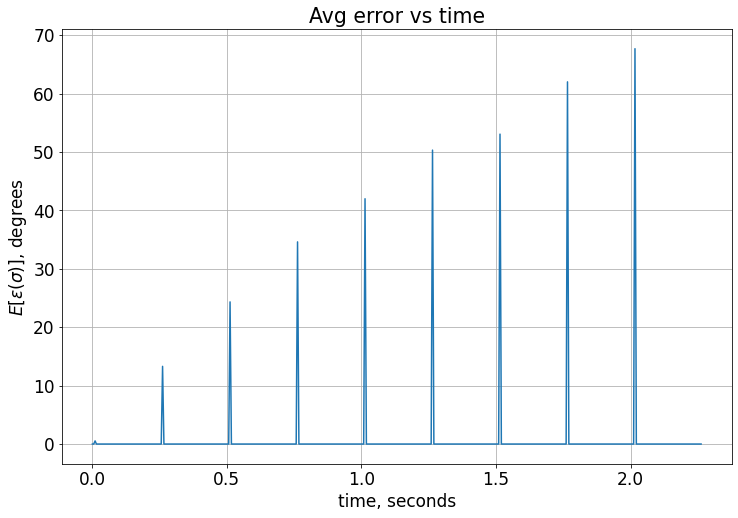

In [261]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(12,8))
plt.grid()
plt.title("Avg error vs time")
plt.ylabel("$E[\epsilon(\sigma)]$, degrees")
plt.xlabel("time, seconds")
plt.plot(time, errors);

In [262]:
dt_sample = dt[:len(results)]
angle_v_sample = angle_v[:len(results)] - results
gt_quat_sample = gt_quat[:len(results)]

In [265]:
errors_biased = calculate_errors_full(500, 1000, 50, dt_sample, angle_v_sample, gt_quat_sample)

2
52
102
152
202
252
302
352
402
452


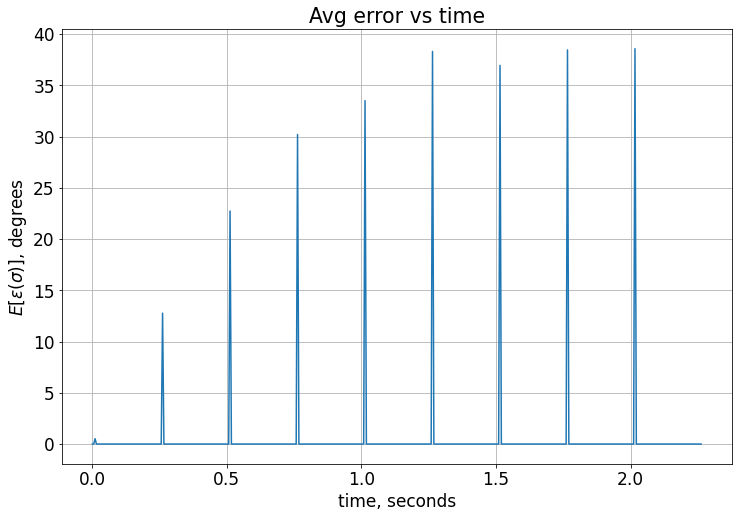

In [267]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(12,8))
plt.grid()
plt.title("Avg error vs time")
plt.ylabel("$E[\epsilon(\sigma)]$, degrees")
plt.xlabel("time, seconds")
plt.plot(time, errors_biased);